In [7]:
%matplotlib inline

import rasterio as rio
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from glob import glob
import os

/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


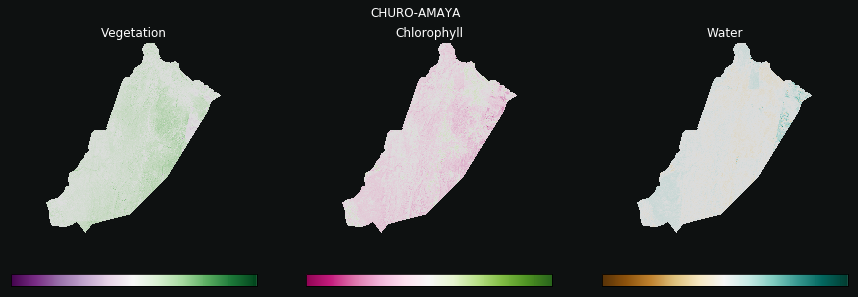

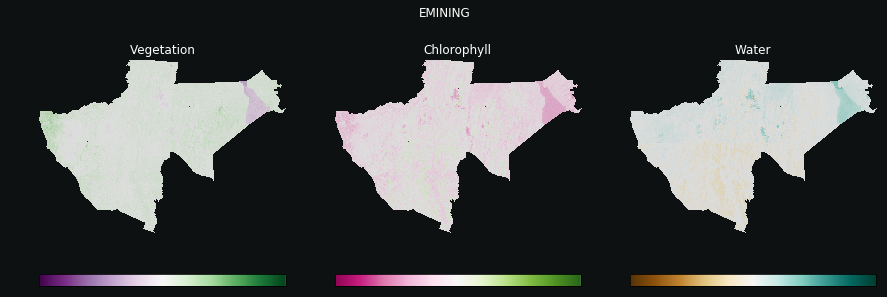

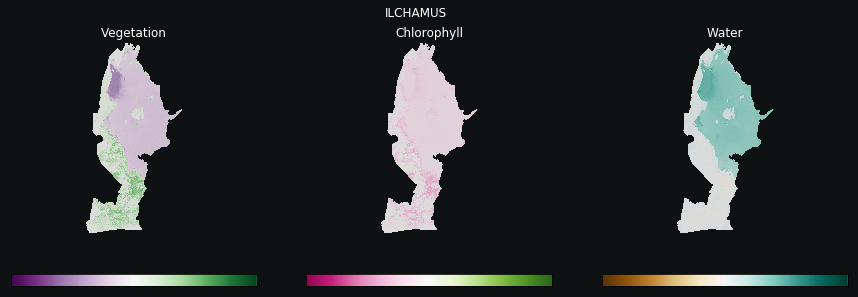

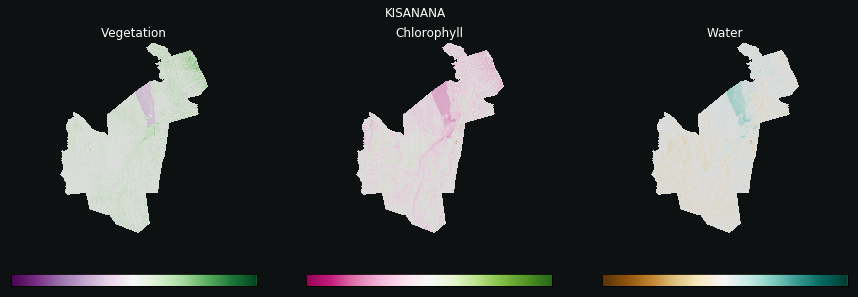

/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/bull/anaconda3/envs/farmdrive/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in long_scalars


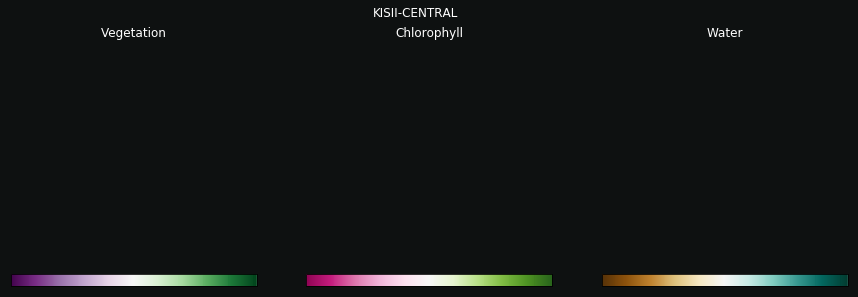

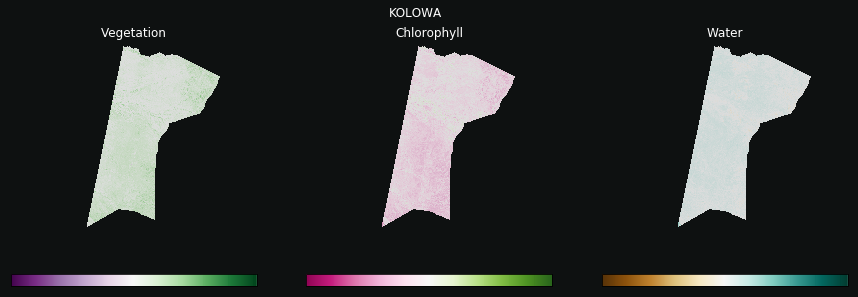

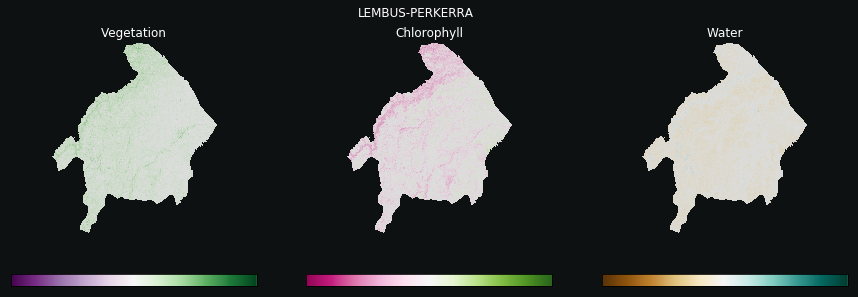

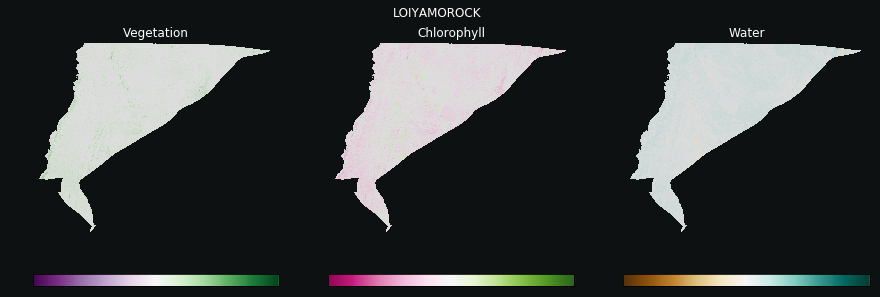

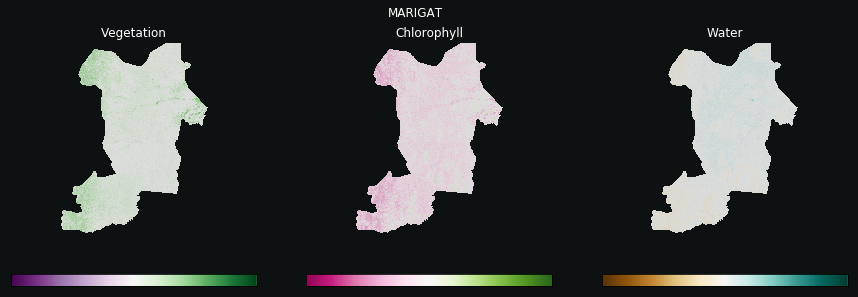

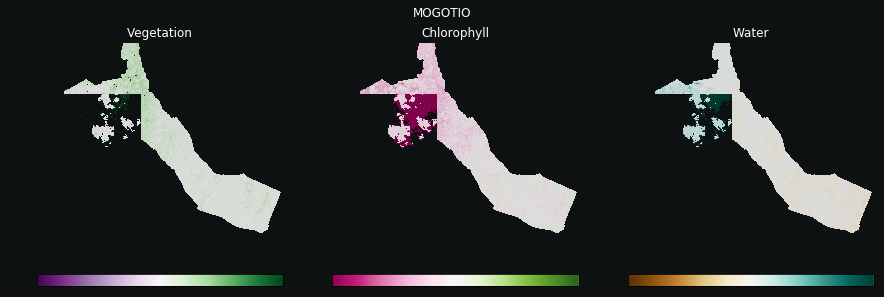

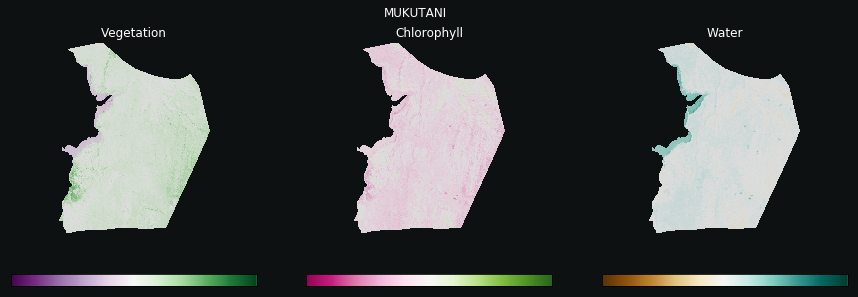

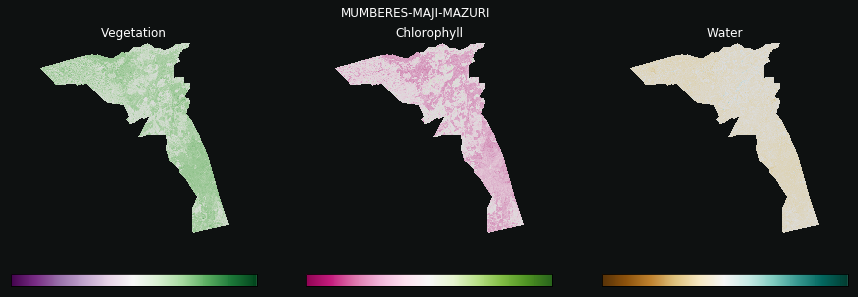

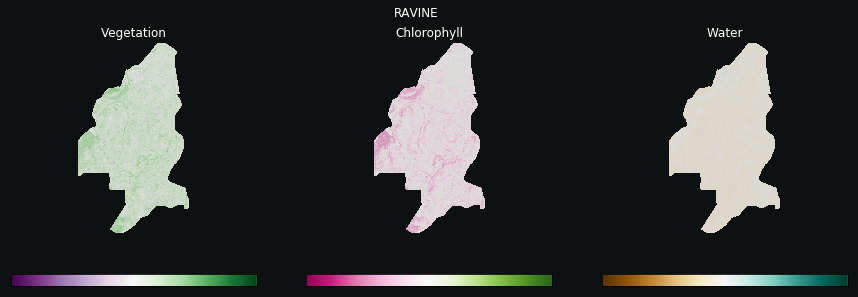

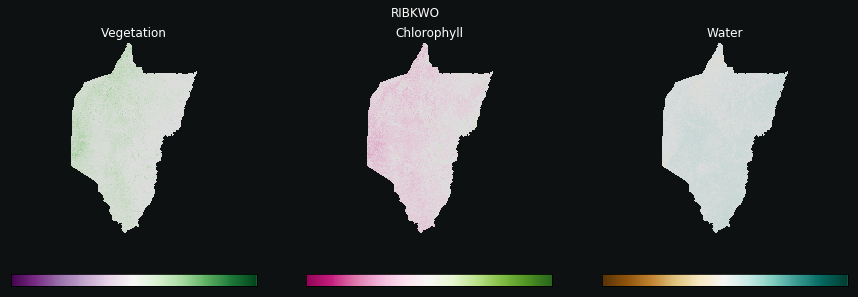

In [8]:
def plot_normalized_indices(title, values, names, colormaps, output_folder=None, base_size=5):
    font = {'color': 'white'}
    
    fig, axes = plt.subplots(1,
                             len(names),
                             facecolor='#0e1111',
                             figsize=(base_size * len(names), base_size),
                            )

    fig.suptitle(title, fontdict=font)

    for ax, val, name, cmap in zip(axes, values, names, colormaps):

        im = ax.imshow(val, cmap=cmap, alpha=0.9, vmin=-1, vmax=1)
        fig.colorbar(im, ax=ax, orientation='horizontal', ticks=[])
        
        ax.set_title(name, fontdict=font)
        ax.axis('off')
        
    if output_folder is not None:
        plt.savefig(os.path.join(output_folder, title + '.png'))
    else:        
        plt.show()
    
    
def summary_stats(measure):
    mean = np.nanmean(measure)
    std = np.nanstd(measure)
    
    not_nan_mask = ~np.isnan(measure)
    measure_no_nan = measure[not_nan_mask]
    
    # very_likely % (> 0.25, on the range of the measure -1..1)
    very_likely = (measure_no_nan > 0.25).sum() / not_nan_mask.sum()
    
    return mean, std, very_likely
    
    
def summary_stats_series(ward, all_measures, names):
    stats_labels = ['mean', 'std', 'pct_likely']

    series = dict()
    for n, measure in zip(names, all_measures):
        for label, val in zip(stats_labels, summary_stats(measure)):
            series["{}_{}".format(n, label)] = val
            
    return pd.Series(series, name=ward)
    

def process_wards_normalized_indices(root_folder):
    
    all_ward_data = []    

    for f in glob(os.path.join(root_folder, '*_fall')):
        ward = f.split(str(os.path.sep))[-1].split("_")[0]

        if ward != 'failed':
            analytic_file = os.path.join(f, "{}_fall_analytic.tif".format(ward))

            if os.path.exists(analytic_file):
                data = rio.open(analytic_file)

                b, g, r, re, nir = data.read()


                # re_vegetation index
                re_ndvi = (nir - re) / (nir + re)


                # pigment chlorophyll
                npcri = (r - b) / (r + b)

                # water_index
                re_ndwi = (g - re) / (g + re)

                ward_data = summary_stats_series(ward,
                                                 [re_ndvi, npcri, re_ndwi],
                                                 ['re_ndvi', 'npcri', 're_ndwi'])

                all_ward_data.append(ward_data)

                plot_normalized_indices(ward,
                                        [re_ndvi, npcri, re_ndwi],
                                        ['Vegetation', 'Chlorophyll', 'Water'],
                                        [plt.cm.PRGn, plt.cm.PiYG, plt.cm.BrBG])

            else:
                pass
                print("DOES NOT EXIST: ", analytic_file)

    ward_df = pd.DataFrame(all_ward_data)
    ward_df.to_csv(os.path.join(root_folder, 'all_ward_data.csv'))
    
    
process_wards_normalized_indices('../data/raw/planet/wards/')

            